In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import io
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
import lightgbm as lgb
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, plot_confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import classification_report, mean_squared_error
from itertools import cycle
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
import math

warnings.filterwarnings("ignore");

/Users/miracl6/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Description

Attribute Information:

For more information, read [Cortez et al., 2009]. 
Input variables (based on physicochemical tests): 
- 1 - fixed acidity 
- 2 - volatile acidity 
- 3 - citric acid 
- 4 - residual sugar 
- 5 - chlorides 
- 6 - free sulfur dioxide 
- 7 - total sulfur dioxide 
- 8 - density 
- 9 - pH 
- 10 - sulphates 
- 11 - alcohol 

Output variable (based on sensory data): 

- 12 - quality (score between 0 and 10)

# Preparation

### Load dataset

In [4]:
# Red vine
df_r = pd.read_csv("winequality-red.csv", sep=';')

# White vine
df_w = pd.read_csv("winequality-white.csv", sep=';')

In [5]:
df_r['wine'] = 'red'
df_w['wine'] = 'white'

In [6]:
df = df_r.append(df_w)
x_ = df[['quality']]
df = df.drop('quality', axis=1)
df = pd.concat([df, x_], axis=1)

In [7]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,red,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,red,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,red,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,red,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,red,5


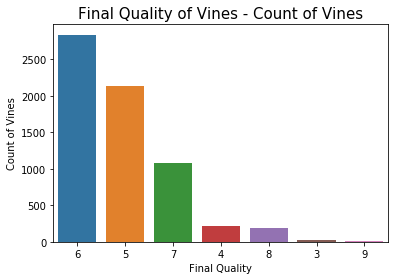

In [8]:
sns.countplot(data=df, x='quality', order=df.quality.value_counts().index)
plt.title('Final Quality of Vines - Count of Vines',fontsize=15)
plt.xlabel('Final Quality'); plt.ylabel('Count of Vines');

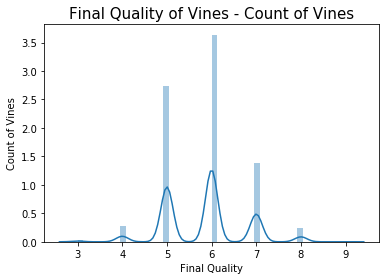

In [9]:
sns.distplot(df['quality'])
plt.title('Final Quality of Vines - Count of Vines',fontsize=15)
plt.xlabel('Final Quality'); plt.ylabel('Count of Vines');

Descriptive statistics is a helpful way to understand characteristics of your data and to get a quick summary of it. The describe function applies basic statistical computations: extreme values, count of data points standard deviation etc, excluding NaN values.

In [10]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Checking feature information

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
wine                    6497 non-null object
quality                 6497 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 870.6+ KB


Checking missing values

In [12]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
wine                    0
quality                 0
dtype: int64

# Exploratory data analysis

### Heatmap of correlations

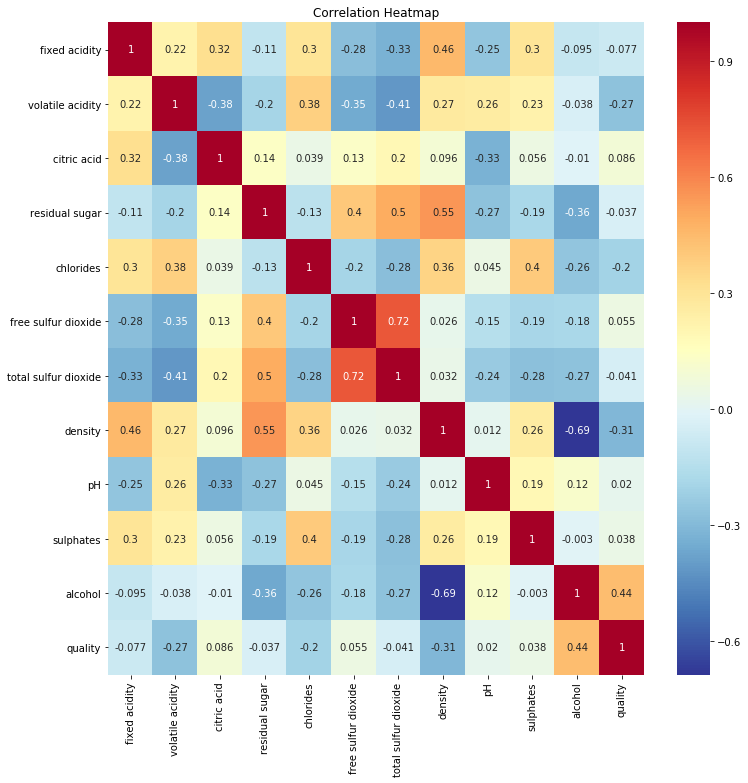

In [13]:
corr = df.corr()
plt.figure(figsize = (12, 12))

sns.heatmap(corr, cmap = plt.cm.RdYlBu_r, annot = True)
plt.title('Correlation Heatmap');

The total sulfur dioxide correlate with the free sulfur dioxide, also alcohol have inverse proportional with density.

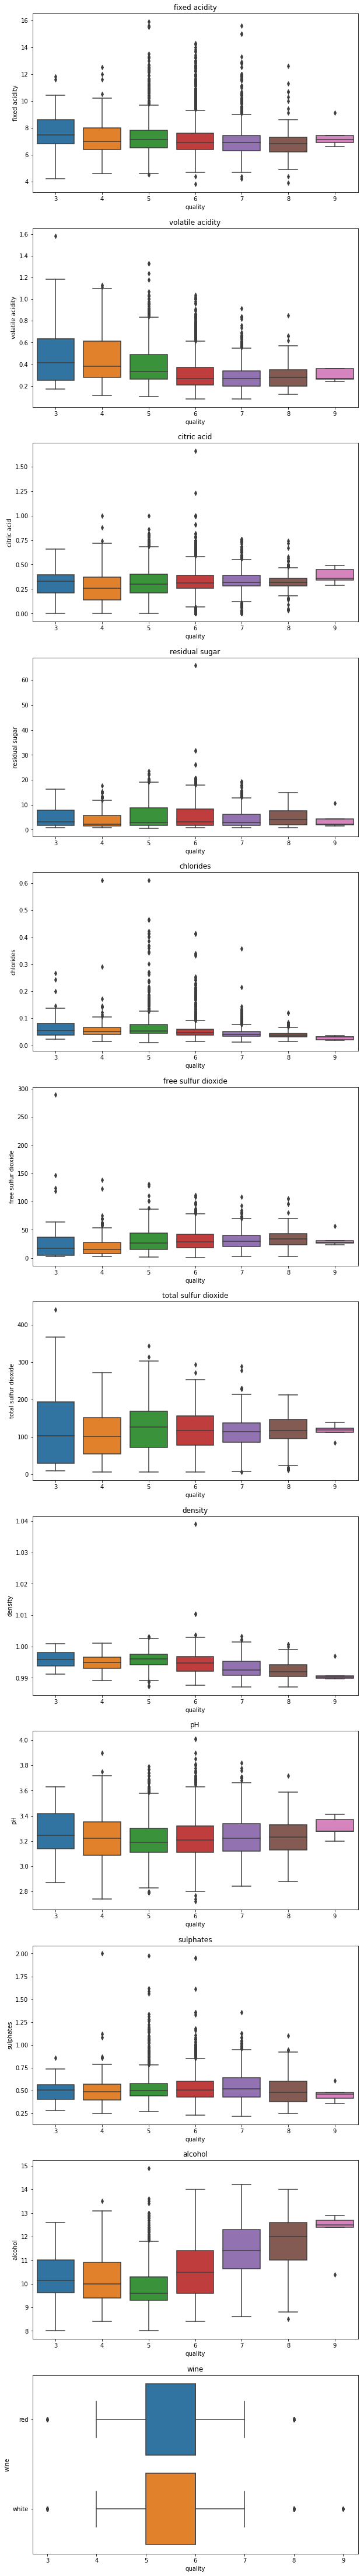

In [14]:
fig,ax = plt.subplots(len(df.columns[:-1]),1, figsize=(10,80))

for i, col in enumerate(df.columns[:-1]):
    p1 = sns.boxplot(x = 'quality', y = col, data=df, ax=ax[i]).set_title(col)

The significant difference quality wine is a limited range of degrees of alcohol and total sulfur dioxide.

## Regression

### Prepare Dataset for Modelling

In [15]:
le = LabelEncoder()
X = pd.get_dummies(df.drop(['quality'], axis=1)).values
y = le.fit_transform(df['quality'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## Logistic Regression

Find the best hyperameters for model

In [16]:
lr = LogisticRegression()
lr_params = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}

grid_search_lr = GridSearchCV(lr, param_grid = lr_params, cv = 10)
grid_search_lr.fit(X_train,y_train)
grid_search_lr.best_estimator_

LogisticRegression(C=25, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
lr = LogisticRegression(penalty='l2', C=25)

In [18]:
def train_kfold(X_train, y_train, model, y_test, X_test):
    kf = KFold(n_splits=10,shuffle=True)
    pred_test_full =0
    cv_score =[]
    i=1

    for train_index, test_index in kf.split(X_train, y_train):
        X_train_, X_test_ = X_train[train_index], X_train[test_index]
        y_train_, y_test_ = y_train[train_index], y_train[test_index]
        model.fit(X_train_,y_train_)
        #RMSE
        score = math.sqrt(mean_squared_error(y_test_,model.predict(X_test_)))
        cv_score.append(score)    
        pred_test = lr.predict_proba(X_test)[:,1]
        pred_test_full +=pred_test
        i+=1
    print('Mean cv Score',np.mean(cv_score))

    return np.mean(cv_score)

In [19]:
cv_lr = train_kfold(X_train, y_train, lr, y_test, X_test)

Mean cv Score 0.8939782669285788


## Decision Tree

In [20]:
dt = DecisionTreeRegressor()

dt_params = {'criterion': ['mse', 'rmse', 'mae'],
            'max_depth': [2,3,4,6,8,12]}

grid_search_dt = GridSearchCV(dt, param_grid = dt_params, cv = 10)
grid_search_dt.fit(X_train,y_train)
grid_search_dt.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [21]:
dt = DecisionTreeRegressor(max_depth=6, criterion='mse')

In [22]:
cv_dt = train_kfold(X_train, y_train, dt, y_test, X_test)

Mean cv Score 0.7302003241721773


## Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf_params = {'max_depth' : [2,3,4,6,8],
            'criterion' :['mse', 'rmse','mae']}

grid_search_rf = GridSearchCV(rf, param_grid = rf_params, cv = 10)
grid_search_rf.fit(X_train,y_train)
grid_search_rf.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [24]:
rf = RandomForestRegressor(max_depth=6, criterion='mse')

In [25]:
cv_rf = train_kfold(X_train, y_train, rf, y_test, X_test)

Mean cv Score 0.6931569348063681


## XGB Regression

In [26]:
from xgboost import XGBRFRegressor

xgb = XGBRFRegressor()

xgb_params = {'objective': ['reg:squarederror'],
                'gamma' :  [0.5, 1, 1.5, 2, 5],
            'max_depth' : [2,3,4,6,8,12]}

grid_search_xgb = GridSearchCV(xgb, param_grid = xgb_params, cv = 10)
grid_search_xgb.fit(X_train,y_train)
grid_search_xgb.best_estimator_

XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
               colsample_bytree=1, gamma=0.5, learning_rate=1, max_delta_step=0,
               max_depth=12, min_child_weight=1, missing=None, n_estimators=100,
               n_jobs=1, nthread=None, objective='reg:squarederror',
               random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=None, subsample=0.8, verbosity=1)

In [35]:
xgb = XGBRFRegressor(gamma=0.5, max_depth=12, objective = 'reg:squarederror')

In [36]:
cv_xgb = train_kfold(X_train, y_train, xgb, y_test, X_test)

Mean cv Score 0.6926746645530918


## LGBMClassifier

In [29]:
import lightgbm as lgb

lgb_ = lgb.LGBMRegressor()

lgb_params = {'n_estimators' :  [100, 200],
              'max_depth' : [2,3,4,6,8,12]}

grid_search_lgb = GridSearchCV(lgb_, param_grid = lgb_params, cv = 10)
grid_search_lgb.fit(X_train,y_train)
grid_search_lgb.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=12,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [37]:
lgb_ = lgb.LGBMRegressor(max_depth=12, n_estimators=200)

In [38]:
cv_lgb = train_kfold(X_train, y_train, lgb_, y_test, X_test)

Mean cv Score 0.6329015999709866


## Model Selection

In [39]:
table_finish = pd.DataFrame()
table_finish['model'] = ['Logistic Regression', 'Decision Tree', 'RandomForest' , 'XGBRegression', 'LGBMRegression']
table_finish['cv_score'] = [cv_lr, cv_dt, cv_rf, cv_xgb, cv_lgb]

In [40]:
table_finish.set_index('model')

,cv_score
model,
Logistic Regression,0.893978
Decision Tree,0.730200
RandomForest,0.693157
XGBRegression,0.692675
LGBMRegression,0.632902


In [41]:
print('LGBMRegression model selected')

LGBMRegression model selected


## Feature Importance

In [42]:
cols = pd.get_dummies(df.drop('quality', axis=1)).columns

cols = cols[np.where(lgb_.feature_importances_>0)[0]]
df_fpm = pd.DataFrame()
df_fpm['f'] = cols
df_fpm['imp'] = 0
df_fpm['imp'] = list(lgb_.feature_importances_[lgb_.feature_importances_>0])

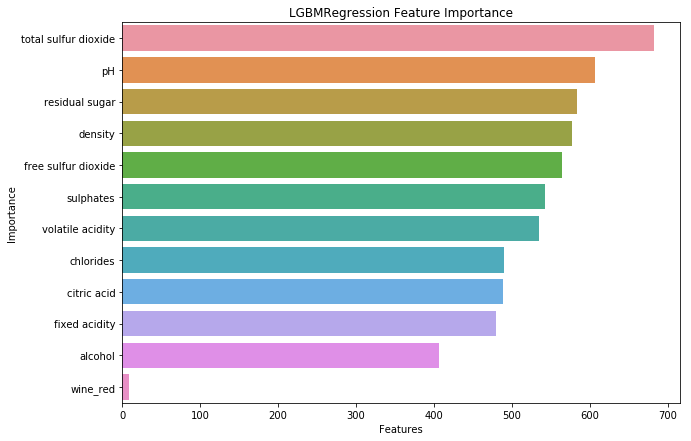

In [43]:
plt.figure(figsize=(10, 7))
sns.barplot(x="imp", y="f", data=df_fpm.sort_values(by='imp', ascending=False))
plt.title('LGBMRegression Feature Importance');
plt.xlabel('Features'); plt.ylabel('Importance');

Total sulfur dioxide has the greatest importance for the quality of wine. 

Quality of wine doesn't depend of color. 